In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from create_custom_classifier import get_target_recordings
from create_custom_classifier import search_recordings
from create_custom_classifier import get_missing_species

import collections
from etils import epath
from ml_collections import config_dict
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
from typing import List

from chirp import audio_utils
from chirp.inference import a2o_utils
from chirp.inference import interface
from chirp.inference import tf_examples
from chirp.inference import models
from chirp.models import metrics
from chirp.taxonomy import namespace
from chirp.inference.search import bootstrap
from chirp.inference.search import search
from chirp.inference.search import display
from chirp.inference.classify import classify
from chirp.inference.classify import data_lib
import requests
import json
import pickle
import sys
from scipy.io import wavfile
import os
from importlib import reload

2024-06-24 11:31:12.113796: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 11:31:12.113851: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 11:31:12.113860: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# load embedding config
working_dir =  '.'
embeddings_path = epath.Path(working_dir) / 'embeddings'
labeled_data_path = epath.Path(working_dir) / 'labeled_outputs'
custom_classifier_path = epath.Path(working_dir) / 'custom_classifier'
target_recordings_path = epath.Path(working_dir) / 'target_recordings'
bootstrap_config = bootstrap.BootstrapConfig.load_from_embedding_path(
      embeddings_path=embeddings_path,
      annotated_path=labeled_data_path)

project_state = bootstrap.BootstrapState(
    bootstrap_config, a2o_auth_token='')
window_s = bootstrap_config.model_config['window_size_s']
sample_rate = bootstrap_config.model_config['sample_rate']

In [4]:
# Downloading a few sample recordings for each species

bird_list = pd.read_csv('bird_list.csv')['code'].to_list()

get_target_recordings(['herwar'], ['song'], 3, target_recordings_path, sample_rate, window_s)

8
Getting recordings for herwar: Setophaga occidentalis
xc recording xc572272 already exists, skipping
xc recording xc436827 already exists, skipping
xc recording xc436826 already exists, skipping
xc recording xc436825 already exists, skipping
xc recording xc748361 already exists, skipping
xc recording xc745065 already exists, skipping
xc recording xc744957 already exists, skipping
xc recording xc737877 already exists, skipping


Results Page: 0 / 2


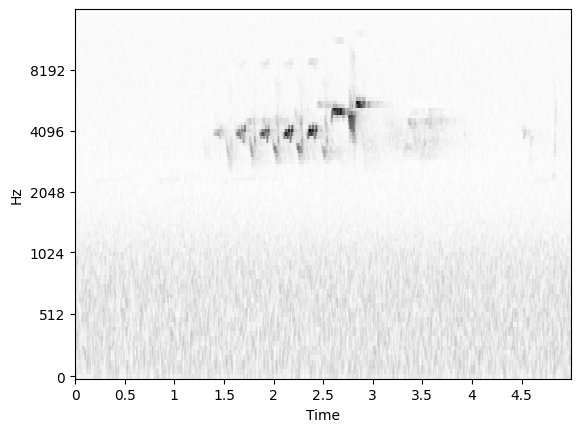

rank        : 0
source file : 10-BLACK/Data/BLACK-10-CAP_20230609_080000.wav
offset_s    : 340.00
score       : 6.08


Button(description='unknown', style=ButtonStyle())

Button(description='herwar_call', style=ButtonStyle())

Button(description='herwar_song', style=ButtonStyle())

--------------------------------------------------------------------------------


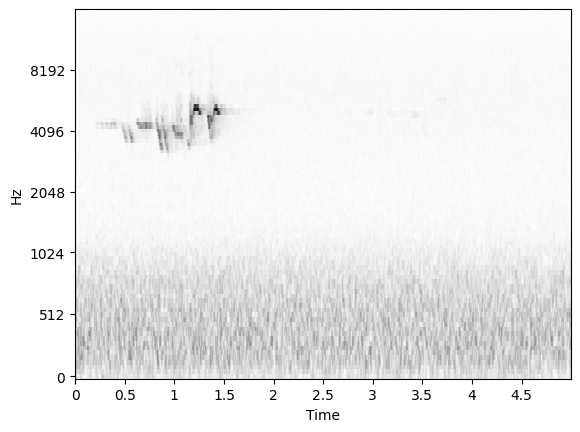

rank        : 1
source file : 20_PARROT/Data/20-PARROT_20230619_063000.wav
offset_s    : 485.00
score       : 5.90


Button(description='unknown', style=ButtonStyle())

Button(description='herwar_call', style=ButtonStyle())

Button(description='herwar_song', style=ButtonStyle())

--------------------------------------------------------------------------------


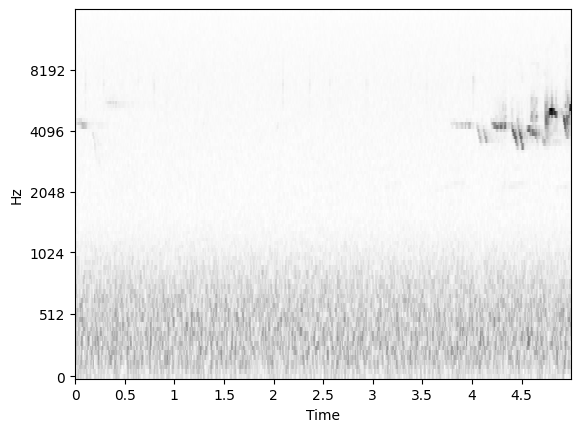

rank        : 2
source file : 20_PARROT/Data/20-PARROT_20230619_063000.wav
offset_s    : 525.00
score       : 5.80


Button(description='unknown', style=ButtonStyle())

Button(description='herwar_call', style=ButtonStyle())

Button(description='herwar_song', style=ButtonStyle())

--------------------------------------------------------------------------------


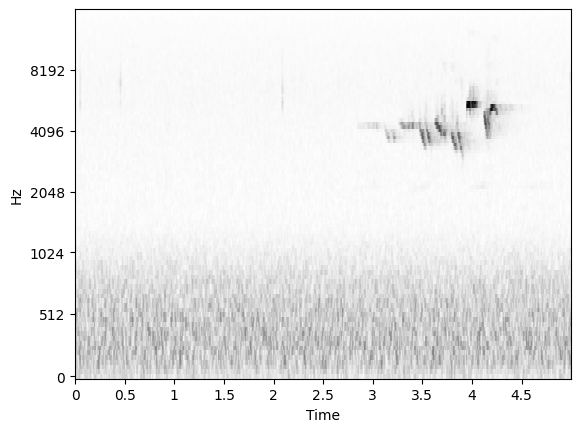

rank        : 3
source file : 20_PARROT/Data/20-PARROT_20230619_063000.wav
offset_s    : 540.00
score       : 5.77


Button(description='unknown', style=ButtonStyle())

Button(description='herwar_call', style=ButtonStyle())

Button(description='herwar_song', style=ButtonStyle())

--------------------------------------------------------------------------------


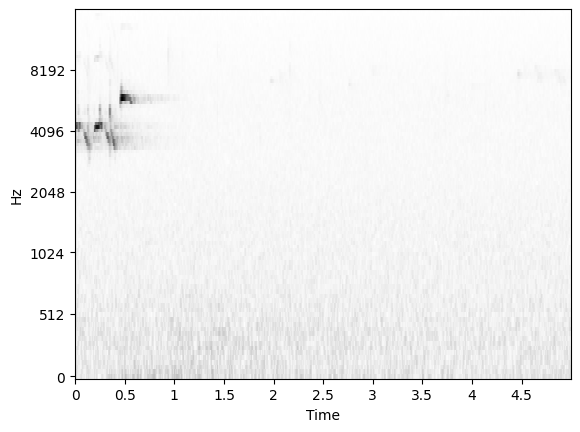

rank        : 4
source file : 4-RED_mini/Data/4-RED_20230613_160000.wav
offset_s    : 40.00
score       : 5.76


Button(description='unknown', style=ButtonStyle())

Button(description='herwar_call', style=ButtonStyle())

Button(description='herwar_song', style=ButtonStyle())

--------------------------------------------------------------------------------


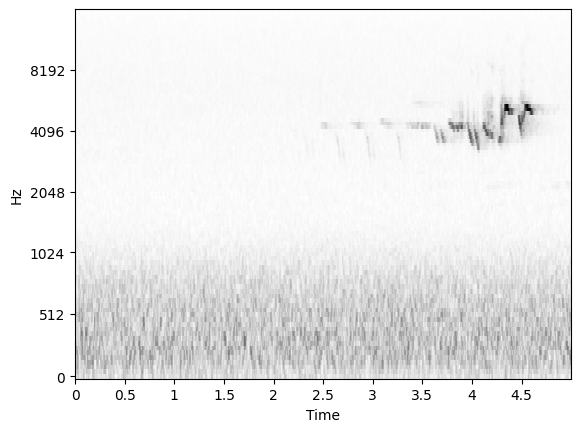

rank        : 5
source file : 20_PARROT/Data/20-PARROT_20230619_063000.wav
offset_s    : 570.00
score       : 5.76


Button(description='unknown', style=ButtonStyle())

Button(description='herwar_call', style=ButtonStyle())

Button(description='herwar_song', style=ButtonStyle())

--------------------------------------------------------------------------------


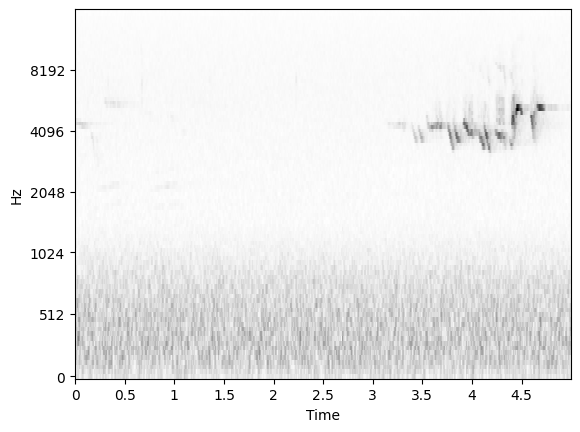

rank        : 6
source file : 20_PARROT/Data/20-PARROT_20230619_063000.wav
offset_s    : 555.00
score       : 5.68


Button(description='unknown', style=ButtonStyle())

Button(description='herwar_call', style=ButtonStyle())

Button(description='herwar_song', style=ButtonStyle())

--------------------------------------------------------------------------------


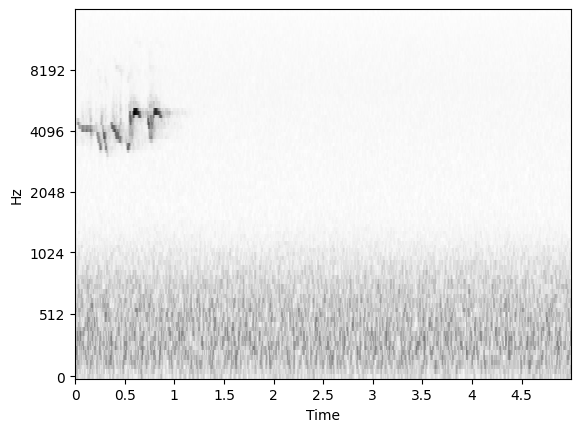

rank        : 7
source file : 20_PARROT/Data/20-PARROT_20230619_063000.wav
offset_s    : 420.00
score       : 5.55


Button(description='unknown', style=ButtonStyle())

Button(description='herwar_call', style=ButtonStyle())

Button(description='herwar_song', style=ButtonStyle())

--------------------------------------------------------------------------------
Results Page: 0 / 2


Button(description='Prev Page', style=ButtonStyle())

Button(description='Next Page', style=ButtonStyle())

In [7]:
results = search_recordings(target_recordings_path, 
                  labeled_data_path,
                  working_dir,
                  None, 
                  sample_rate, 
                  project_state,
                  bootstrap_config)

In [6]:
results.write_labeled_data(labeled_data_path, sample_rate)

Wrote 4 examples for label herwar_song


In [9]:
# find out how close we are!
bird_list = pd.read_csv('bird_list.csv')['code'].to_list()

labels_done = set(os.listdir(labeled_data_path))

all_labels = set([f'{code}_{type}' for type in ['song', 'call'] for code in bird_list])

recordings_done = pd.read_csv(
    labeled_data_path / epath.Path('finished_targets.csv'))['start'].to_list()

print(len(recordings_done), len(all_labels) * 3)

# all_labels.difference(labels_done)

768 588


In [8]:
get_missing_species(
    labeled_data_path, 
    bird_list, 
    ['song', 'call'],
    10)

{'embeddings-4fd5b578b32840554972': 2,
 'amekes_call': 1,
 'vauswi_call': 6,
 'coohaw_call': 8,
 'pingro_call': 2,
 'annhum_song': 2,
 'casfin_call': 6,
 'linspa_song': 8,
 'pacwre1_call': 1,
 'foxspa_song': 9,
 'houfin_call': 1,
 'lazbun_call': 8,
 'pilwoo_call': 9,
 'clanut_call': 6,
 'amedip_call': 1,
 'embeddings-df074b3651b675f02fb1': 1,
 '.ipynb_checkpoints': 1,
 'chispa_song': 2,
 'amedip_song': 0,
 'amekes_song': 0,
 'amepip_song': 0,
 'amepip_call': 0,
 'annhum_call': 0,
 'batpig1_song': 0,
 'batpig1_call': 0,
 'belkin1_song': 0,
 'belkin1_call': 0,
 'blkpho_song': 0,
 'blkpho_call': 0,
 'bkbwoo_song': 0,
 'btywar_call': 0,
 'brebla_song': 0,
 'brebla_call': 0,
 'brespa_song': 0,
 'brespa_call': 0,
 'buffle_song': 0,
 'buffle_call': 0,
 'bushti_song': 0,
 'bushti_call': 0,
 'cowscj1_song': 0,
 'cowscj1_call': 0,
 'calhum_song': 0,
 'calhum_call': 0,
 'cangoo_song': 0,
 'cangoo_call': 0,
 'casvir_call': 0,
 'chispa_call': 0,
 'clanut_song': 0,
 'cliswa_song': 0,
 'cliswa_call':